<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Vessel_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vessel Segmentation using tiny encoder
## General idea of the method for segmentation

The main goal for this notebook is to segment vessels in an OPTOS image, these images are way too big for a normal encoder with the input as the original size of the image. Therefore we have three aproches to solve this problem:

1.   Use a CPU for training in a workstation to train a model capable of supporting the native resolution of the image.

    * Training with CPU is way too slow for processing the big amount of images, plus the size of network would be huge.

2.   Reescaling the image to fit a model capable of fitting into a GPU for training.

    * GPU's with high memory capacity are expensive. 
    * By resizing the image to a lower resolution a lot of the thin vessels are lost even before reaching the input of the model. Futhermore, at encoding it is hard for the model to encode the thin vessels and gives more attention to bigger objects such eyelashes, optic disc, etc.

3.   Process the image in patches.

To understand this last idea lets imagine we are trying to classify pixels in an image of 3900 x 3072 = 11,980,800 pixels and tell which of these pixels are actually vessels. And now let's try to zoom this image all the way to a tiny square of 64 x 64 = 4096 pixels. As we can see the difference in information is gigantic, but just maybe that zoom allows us to process easier the image, we could be able to tell that a line crossing that tiny square is a vessel from one coner to the oposite is a vessel. 

By doing this we can define a very small model compared to the SOTA models, and train a bunch of patches on it just to tell if there is a vessel or not in the tiny square.

Then the whole worflow would be like this:

$$Image \rightarrow Patches \rightarrow model \rightarrow Processed\_patches \rightarrow Reconstruction \rightarrow Segmented\_Image$$

### Download and unzip data

In [ ]:
from IPython.display import clear_output
!wget "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/EUehNxUGdQlMoQ7Ft92y2GcB_Mwsqm8zG91I4ZmMpe-L3w?download=1"
!sudo chmod 777 "EUehNxUGdQlMoQ7Ft92y2GcB_Mwsqm8zG91I4ZmMpe-L3w?download=1"
!mv "EUehNxUGdQlMoQ7Ft92y2GcB_Mwsqm8zG91I4ZmMpe-L3w?download=1" "VesselsSegmentation.zip"
!unzip VesselsSegmentation.zip
!rm VesselsSegmentation.zip
clear_output(wait=False)
print("Data downloaded")

Data downloaded


### Load packages to use

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

### Load data
The downloaded data has an Original and GroundTruth folders, together with a CSV indicating the relation beetween the files. We have to add the full path to the dataframe.

In [ ]:
path = "./"
data = pd.read_csv(os.path.join(path,"VesselSegmentationOPTOS.csv"))
data.head()

,Original,GroundTruth
0,000562-20170126@122926-R1.tif,000562-20170126@122926-R1.png
1,1108630-20170801.tif,1108630-20170801.png
2,1111489-20170731@CICATRIZ MACULAR (3).tif,1111489-20170731@CICATRIZ MACULAR (3).png
3,1112223-20171216@115442-R2.tif,1112223-20171216@115442-R2.png
4,1112225-20171220@112236-R1.tif,1112225-20171220@112236-R1.png


In [ ]:
## Add full path to data
Original_Column = 'Original'
Output_Column = "GroundTruth"

data[Original_Column] = data[Original_Column].apply(lambda x : os.path.join(os.path.join(path,"Original"),x))
data[Output_Column] = data[Output_Column].apply(lambda x : os.path.join(os.path.join(path,"GroundTruth"),x))
data.head()

,Original,GroundTruth
0,./Original/000562-20170126@122926-R1.tif,./GroundTruth/000562-20170126@122926-R1.png
1,./Original/1108630-20170801.tif,./GroundTruth/1108630-20170801.png
2,./Original/1111489-20170731@CICATRIZ MACULAR (...,./GroundTruth/1111489-20170731@CICATRIZ MACULA...
3,./Original/1112223-20171216@115442-R2.tif,./GroundTruth/1112223-20171216@115442-R2.png
4,./Original/1112225-20171220@112236-R1.tif,./GroundTruth/1112225-20171220@112236-R1.png


In [ ]:
## Split dataset in training and test
from sklearn.model_selection import train_test_split
train,test = train_test_split(data, test_size=0.1, random_state=42)

### Repository with tools
Clone the repository Segmentation_OPTOS which has the tools for the generator.

In [ ]:
!git clone "https://github.com/Vengadore/Segmentation_OPTOS.git"

Cloning into 'Segmentation_OPTOS'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 59 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


To understand the generator let's remember that we want to split the image into patches of a given *patch_size*. Now, creating the total possible patches in the image would be time consuming and might exhaust our memory, therefore we only decide to create *n_patches* from the image, these number of patches will create our batch to feed every step into our training. This means that the total number of steps is equal to the total number of images in the training set!!

Now, how do we choose where to extract the patch from?. Simple, we know the size of the patch is given by *patch_size*, then we just need to find a coordinate $(x,y)$ and extract the patch as $(x:x+patch\_size[0],y:y+patch\_size[1])$. 

To define the coordinates $(x,y)$ we can use a gaussian distribution and say: for $x$ take a sample from the distribution $Normal(M/2,M/5)$ and in the same way take a sample of $Normal(N/2,N/5)$ for $y$. Where $M$ and $N$ are the size of the image. By doing this we will always get a random coordinate $(x,y)$ for every patch, and even when we are processing the same image in the next epoch the patch will be different, therefore helping with overfitting. At the same time by choosing a gaussian distribution we force the generator to take more samples from the center of the image where vessels are usually more present.\\

With all thtis we have a generator that creates different patches every epoch and virtually creating a gigantic dataset for training. This helps a lot with the generalization of the network.

In [ ]:
from Segmentation_OPTOS.Tools.Generators import Patch_generator
Train_generator = Patch_generator.Generator_from_DataFrame(train,patch_size = [64,64],
                                                           X = Original_Column,
                                                           y = Output_Column,
                                                           n_patches = 300)

Test_generator = Patch_generator.Generator_from_DataFrame(test,patch_size = [64,64],
                                                           X = Original_Column,
                                                           y = Output_Column,
                                                           n_patches = 300)

19 files found out of 19 in the DataFrame for X
19 files found out of 19 in the DataFrame for y
A generator object has been created with 300 per image
3 files found out of 3 in the DataFrame for X
3 files found out of 3 in the DataFrame for y
A generator object has been created with 300 per image


## Creation of the network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Dense,BatchNormalization,Flatten,MaxPool2D
from tensorflow.keras.models import Model

In [ ]:
encoder = Sequential()
encoder.add(Conv2D(256,[3,3],strides = (1,1),activation='relu',input_shape = (64,64,3)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(128,[3,3],strides = (1,1),activation='relu'))
encoder.add(BatchNormalization())
encoder.add(Conv2D(64,[3,3],strides = (1,1),activation='relu'))
encoder.add(BatchNormalization())
encoder.add(MaxPool2D(pool_size=(2,2)))

encoder.compile(optimizer = 'adam',loss = 'binary_crossentropy')
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 256)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 58, 58, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 64)        0

In [ ]:
decoder = Sequential()
decoder.add(Conv2DTranspose(64,[3,3],strides = (1,1),activation = 'relu',input_shape = (29,29,64)))
decoder.add(Conv2DTranspose(64,[3,3],strides = (2,2),activation = 'relu',padding = 'same'))
decoder.add(Conv2DTranspose(128,[3,3],strides = (1,1),activation = 'relu',padding = 'same'))
decoder.add(Conv2DTranspose(256,[3,3],strides = (1,1),activation = 'relu'))
decoder.add(Conv2DTranspose(1,[1,1],strides = (1,1),activation = 'sigmoid'))

decoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 62, 62, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 62, 62, 128)       73856     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 1)         257       
Total params: 443,137
Trainable params: 443,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow.keras.backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:
Network = Sequential([encoder,decoder])
Network.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy',jaccard_distance_loss])
Network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 29, 29, 64)        377792    
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 1)         443137    
Total params: 820,929
Trainable params: 820,033
Non-trainable params: 896
_________________________________________________________________


In [ ]:
Network.fit(Train_generator,steps_per_epoch = len(train),
            validation_data = Test_generator,validation_steps = len(test),epochs = 350)

Epoch 1/350
19/19 [==============================] - 11s 554ms/step - loss: 0.2627 - accuracy: 0.9151 - jaccard_distance_loss: 0.4361 - val_loss: 0.3689 - val_accuracy: 0.9422 - val_jaccard_distance_loss: 0.8639
Epoch 2/350
19/19 [==============================] - 11s 556ms/step - loss: 0.2204 - accuracy: 0.9459 - jaccard_distance_loss: 0.3409 - val_loss: 0.2698 - val_accuracy: 0.9465 - val_jaccard_distance_loss: 0.5967
Epoch 3/350
19/19 [==============================] - 11s 558ms/step - loss: 0.2034 - accuracy: 0.9459 - jaccard_distance_loss: 0.3158 - val_loss: 0.2233 - val_accuracy: 0.9470 - val_jaccard_distance_loss: 0.4111
Epoch 4/350
19/19 [==============================] - 11s 558ms/step - loss: 0.1871 - accuracy: 0.9475 - jaccard_distance_loss: 0.2846 - val_loss: 0.2283 - val_accuracy: 0.9428 - val_jaccard_distance_loss: 0.4210
Epoch 5/350
19/19 [==============================] - 11s 559ms/step - loss: 0.1793 - accuracy: 0.9470 - jaccard_distance_loss: 0.2687 - val_loss: 0.2080

In [ ]:
## Save network
!mkdir -p saved_model
Network.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
## Load model
import tensorflow as tf
Network = tf.keras.models.load_model('saved_model/my_model/',custom_objects={"jaccard_distance_loss": jaccard_distance_loss})


Once the model is trained, we can analyze some patches of the test set and see how good it behaves. Aparently it does a good job but also creates some noise around the edges of the image. But let's remember that at the begining we talked about a zoom in the image, lets go back to full scale by zooming out and appending all the patches and rearranging them to form the image

In [ ]:
TEST = next(Test_generator)
R = Network.predict_on_batch(TEST[0])

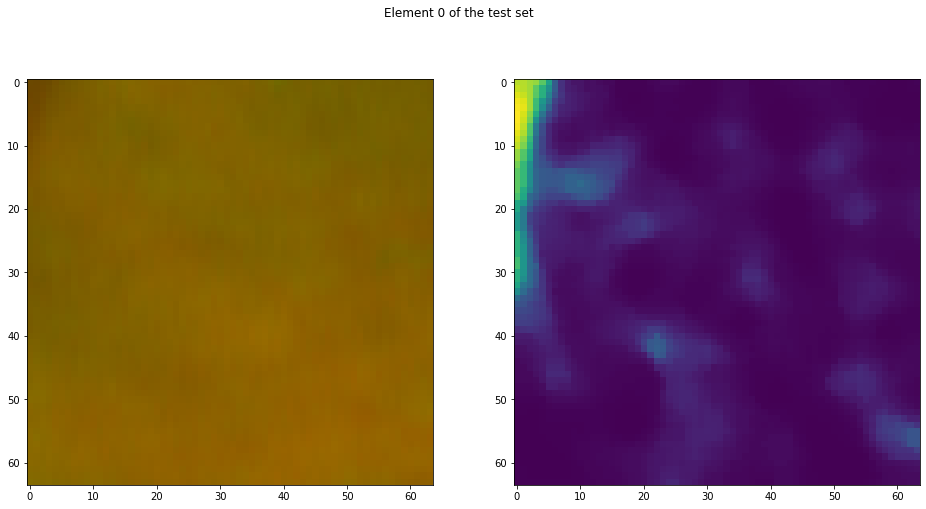

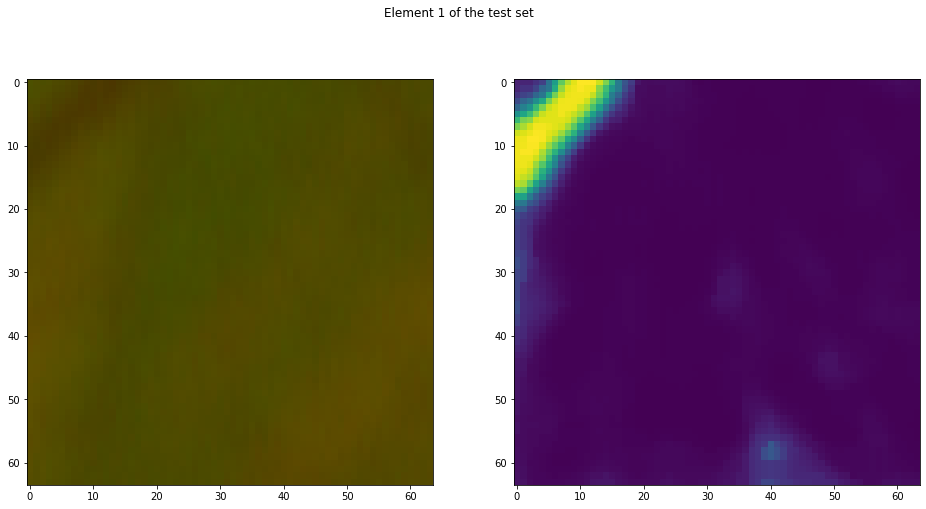

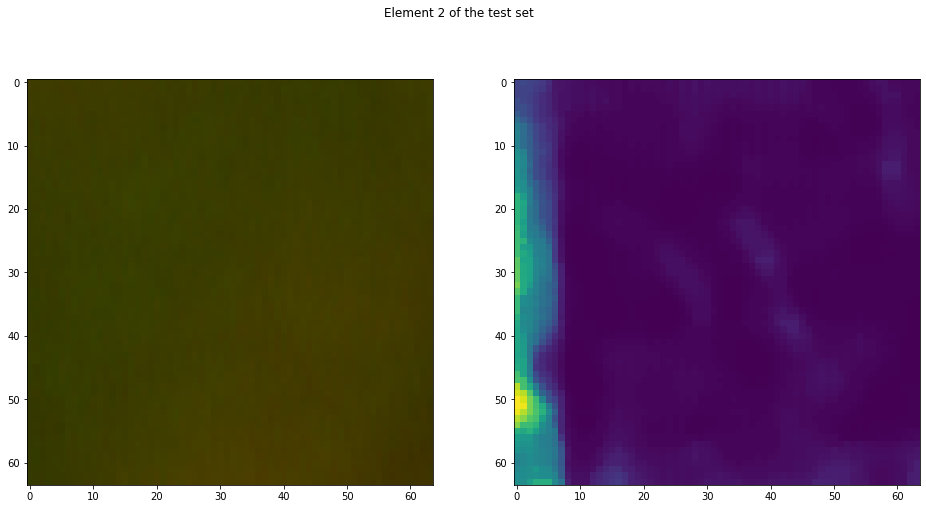

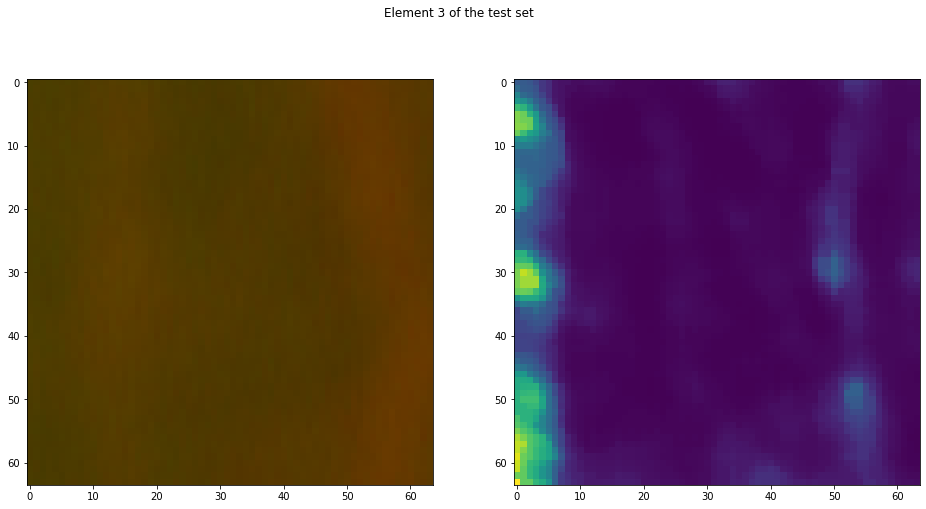

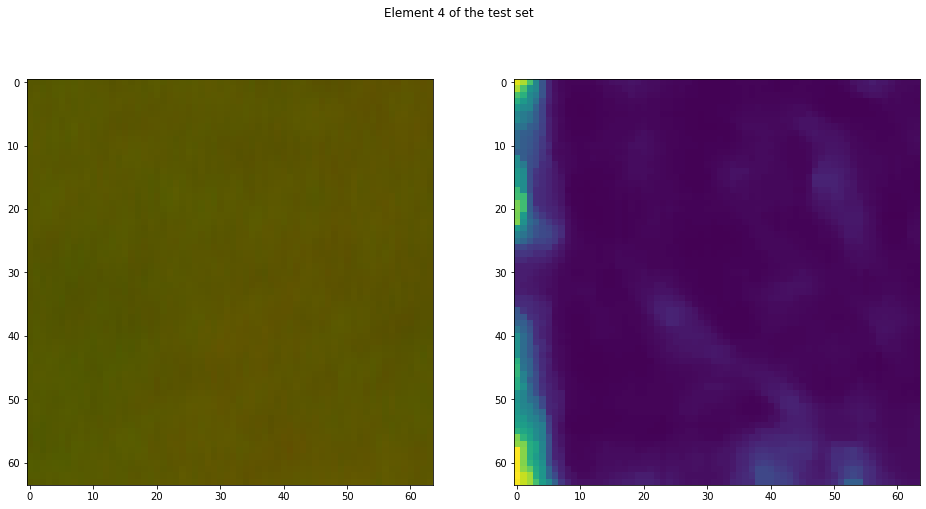

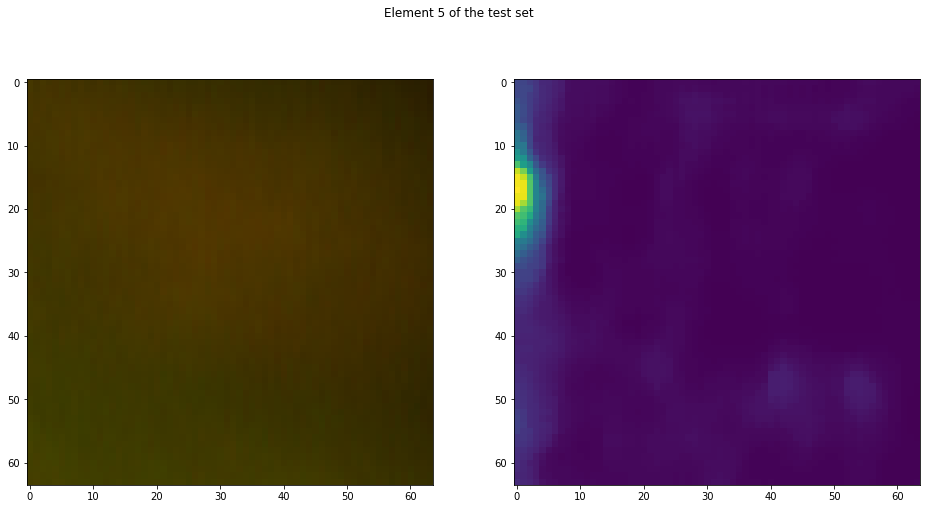

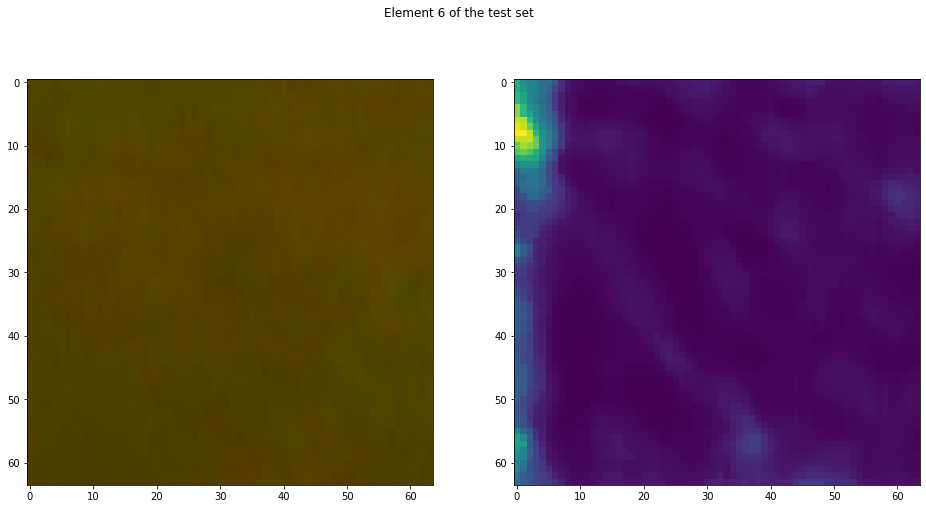

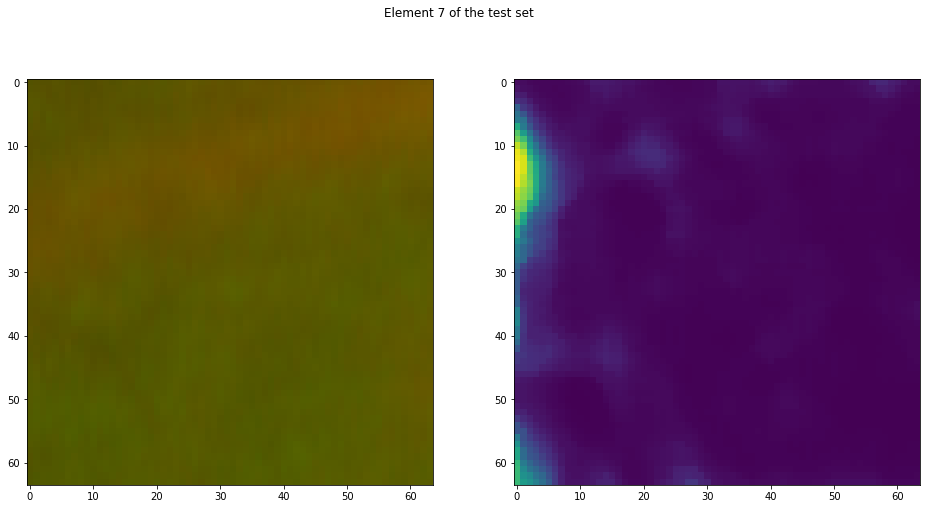

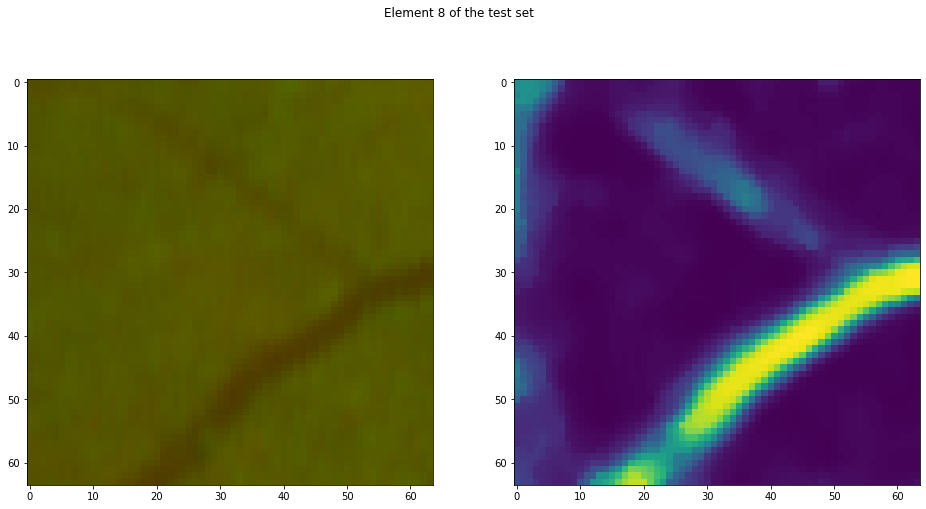

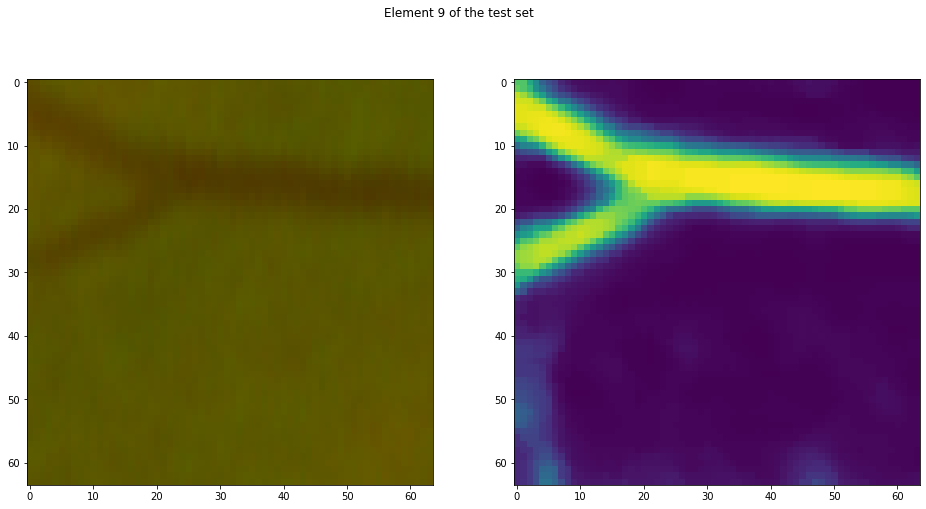

In [ ]:
for n in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))
    fig.suptitle(f"Element {n} of the test set")
    ax1.imshow(TEST[0][n])
    ax2.imshow(cv2.medianBlur(np.reshape(R[n],R[n].shape[0:2]),5))

## Operation in the whole image
To process a whole image first we have to load it into memory, then by using the tools in the "Segmentation_OPTOS" repository we can easily do that.

First by using **Image2Generator** we convert an image into a generator that will yield the necesary patches into the network and process them. The patch size and the batch_size=patches_per_image must be passed to the function.

Then by using **Generator2Image** and passing the trained model and the generator of the image created the output image will be created.

### IMPORTANT!!

At this point we come with a problem given by the use of patches. A lot of noise in the shape of a grid appears together with our vessels in the image. We can try to do several morphological operations and image processing techinques to get rid of them. But an easier solution would be to create a new image with an offset, just by taking a new array making it a little bigger (lets say half of the patch bigger) and then paste the image with that offset on top of the array. Later process that new image and once processed remove the offset.

After this you will have two images with a grid!! but these grids have and offset within each other, simply multiply them and you will get rid of the grids. Then just apply a filter to remove the remaining noise.

By computing the vessels a second time on the same image but with the offset we help the network to compute vessels that might be missing between patches and enhance the result.

***Side Note: Processing of the grid must be improved.

In [ ]:
Image1 = cv2.imread(test['Original'].iloc[2])

In [ ]:
# Compute the output of the network given the original image
I1_generator = Patch_generator.Image2Generator(Image1,patch_size=[64,64],batch_size=300)
I1 = Patch_generator.Generator2Image(Network,I1_generator)

# Resize the first image to a second image to create a bigger array, then place the original in the new array
scale_percent = 110 # percent of original size
width = int(Image1.shape[1] * scale_percent / 100)
height = int(Image1.shape[0] * scale_percent / 100)
dim = (width, height) 
Image2 = 0*cv2.resize(Image1, dim) 
Image2[32:I1_generator.M+32,32:I1_generator.N+32,:] = Image1
I2_generator = Patch_generator.Image2Generator(Image2,patch_size=[64,64],batch_size=300)
I2 = Patch_generator.Generator2Image(Network,I2_generator)
I2 = I2[32:I1_generator.M+32,32:I1_generator.N+32]

A generator object containing all the image has been created
A generator object containing all the image has been created


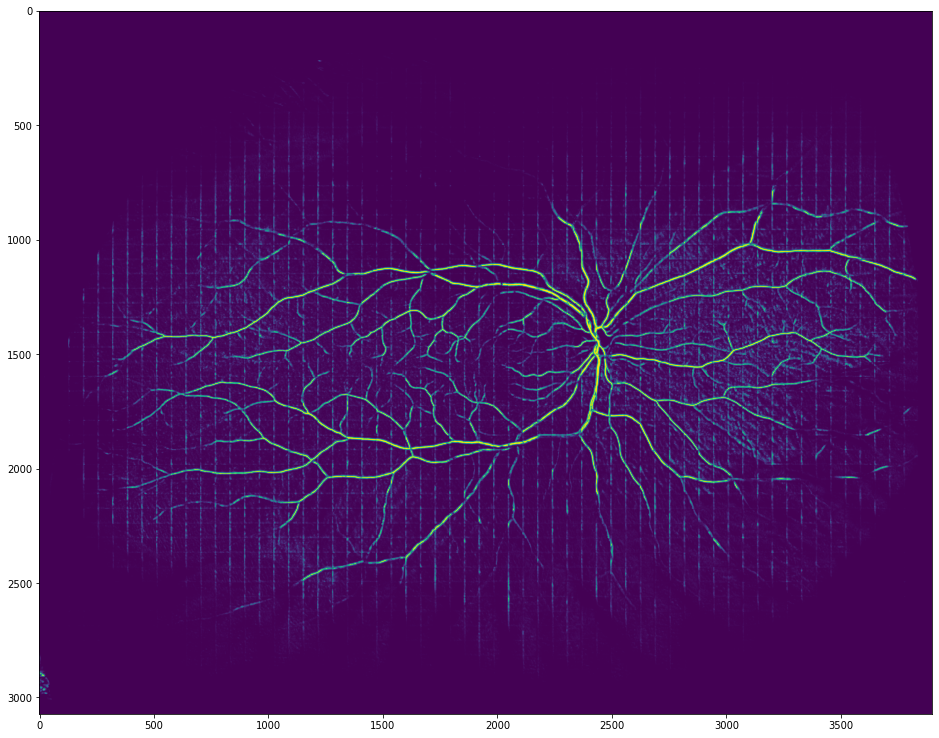

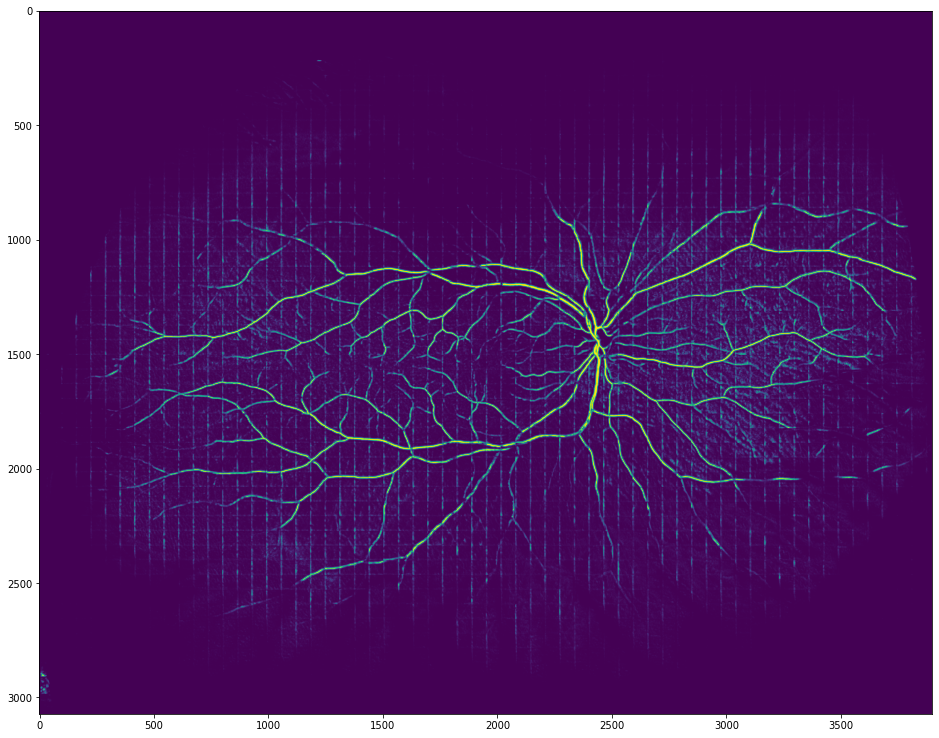

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(I1)
plt.figure(figsize=(16,16))
plt.imshow(I2)

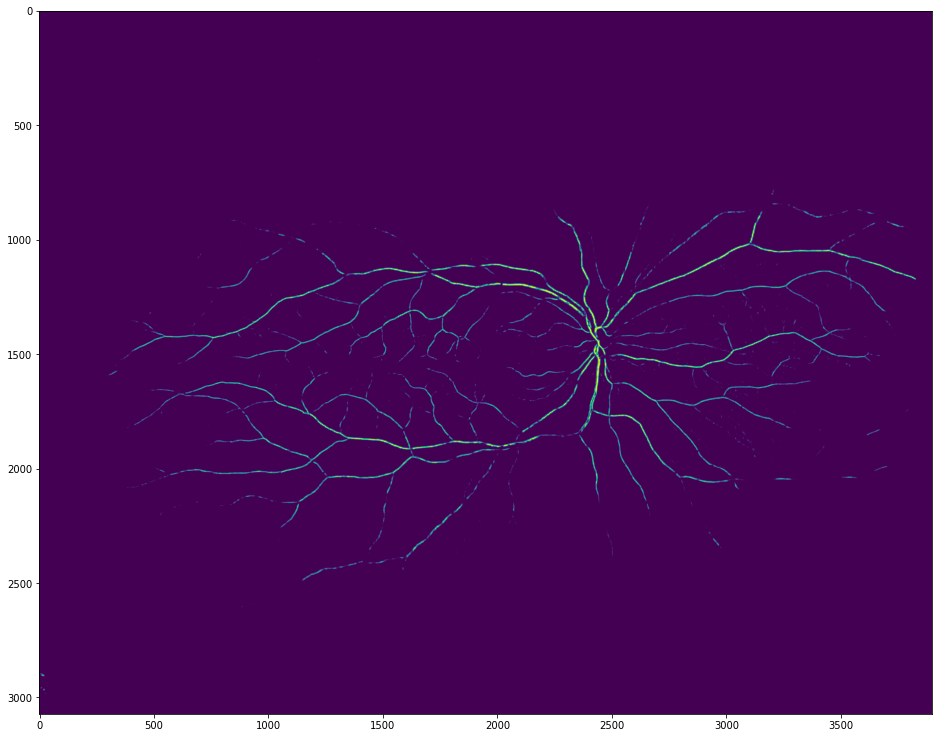

In [ ]:
plt.figure(figsize=(16,16))
I = (100*I1*100*I2)**2
plt.imshow(I)

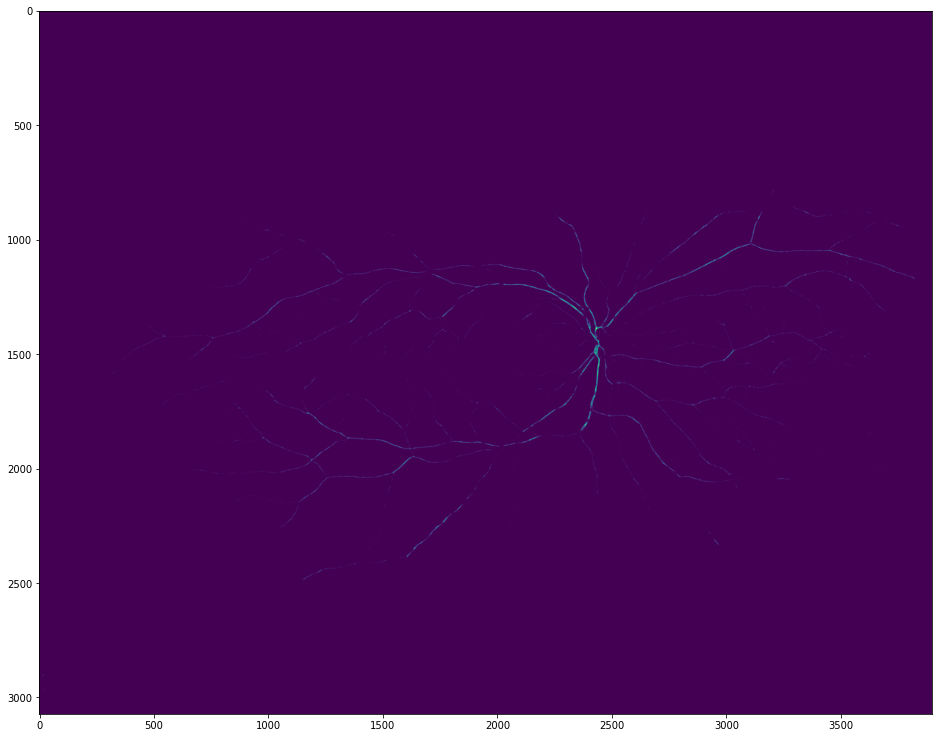

In [ ]:
## Applying a cross kernel with erosion to remove grid
kernel = np.array([[0,0,1,0,0],
                   [0,0,1,0,0],
                   [1,1,1,1,1],
                   [0,0,1,0,0],
                   [0,0,1,0,0]],dtype = np.uint8)
erosion = cv2.erode(I,kernel,iterations = 2)
plt.figure(figsize=(16,16))
plt.imshow(erosion)

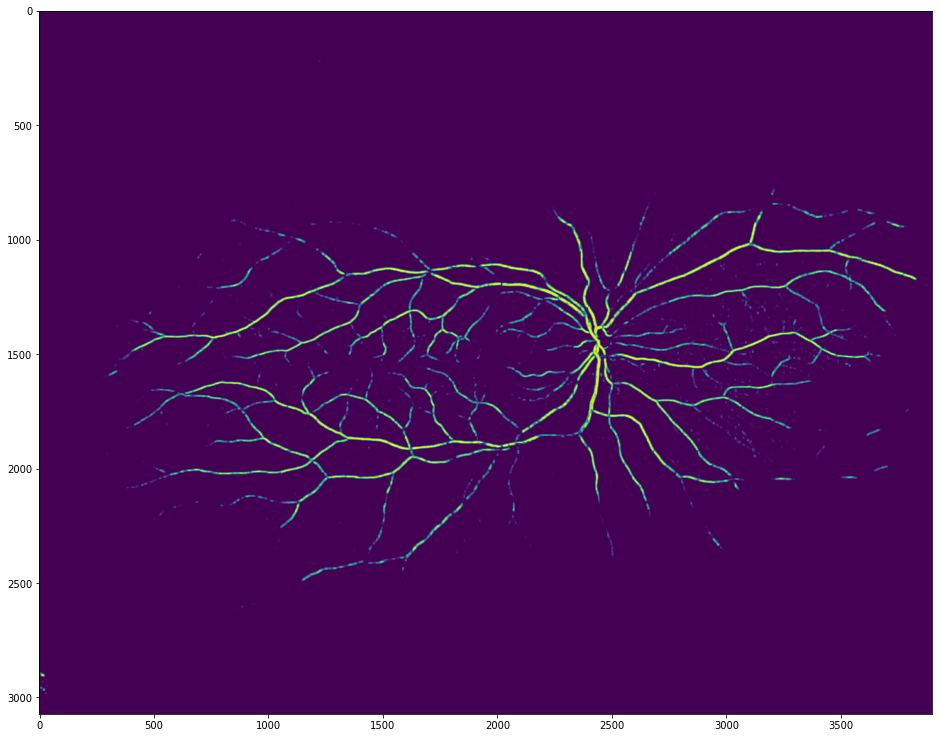

In [ ]:
## Applying a cross kernel with erosion to remove grid
kernel = np.array([[1,0,0,0,1],
                   [0,1,0,1,0],
                   [0,0,1,0,0],
                   [0,1,0,1,0],
                   [1,0,0,0,1]],dtype = np.uint8)
dilate = cv2.dilate(I,kernel,iterations = 1)
plt.figure(figsize=(16,16))
plt.imshow(dilate)

In [ ]:
image = I.copy()
image *= 255.0/image.max() 
image = image.astype(np.uint8)
th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

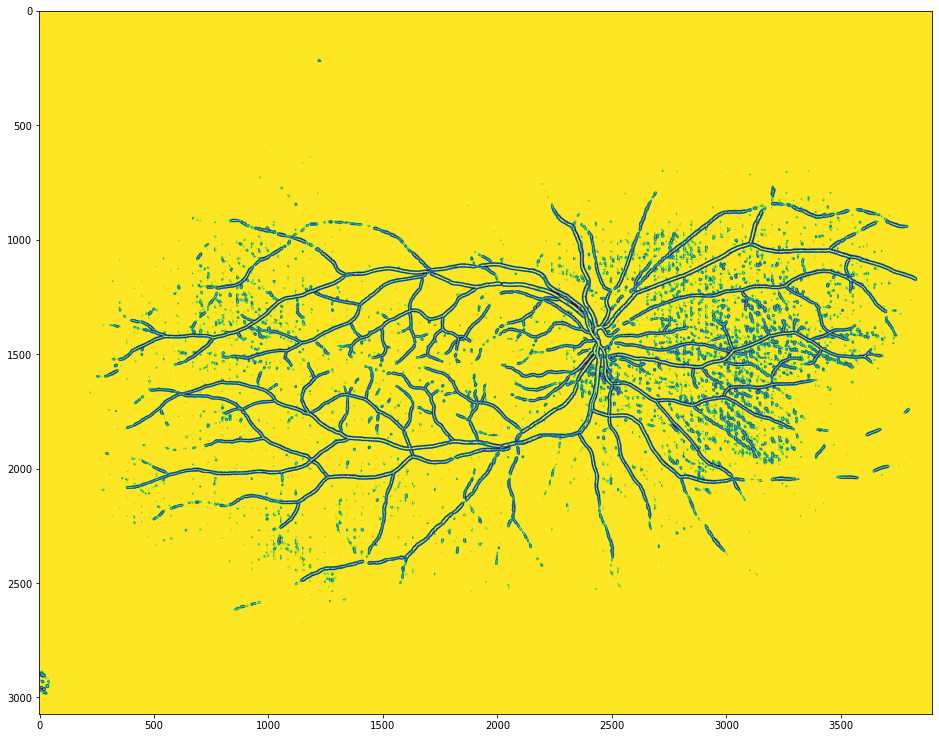

In [ ]:
plt.figure(figsize = (16,16))
plt.imshow(th3)